# 1. 라이브러리 및 데이터

In [1]:
import warnings
import os
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

In [2]:
# 재생산성을 위해 시드 고정 - 7
np.random.seed(7)
random.seed(7)
tf.random.set_random_seed(7)

밝기 온도 채널만 사용하기 위해 0~8채널만 불러오기

약 7만장의 전체 데이터를 사용하지 않고, 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용하기

In [3]:
def trainGenerator():
    
    train_path = 'train'
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        
        dataset = np.load(file)
        
        target = dataset[:,:,-1].reshape(40,40,1)        # target (precipitation)
        cutoff_labels = np.where(target < 0, 0, target) # find error (-9999.xx) and return 0 | return target
        feature = dataset[:,:,:9]                       # feature (0~8 channel data)
        
        if (cutoff_labels > 0).sum() < 1:          
            continue

        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,9]), tf.TensorShape([40,40,1])))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [4]:
train_dataset = train_dataset.batch(512).prefetch(1) # GPU 연산 효율성 증가

In [5]:
test_path = 'test'
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data[:,:,:9])
    
X_test = np.array(X_test)

test: 100%|██████████| 2416/2416 [00:02<00:00, 947.38it/s]


# 2. 데이터 전처리

## Data Cleansing & Pre-Processing

데이터 불러올 시 전처리 로직 적용

강수량에 결측값은 0으로 일괄 대체

# 3. 탐색적 자료 분석
## Exploratory Data Analysis

In [6]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [7]:
image_sample = np.load('train/subset_010462_02.npy')

밝기 온도와 강수량과의 관계 확인하기

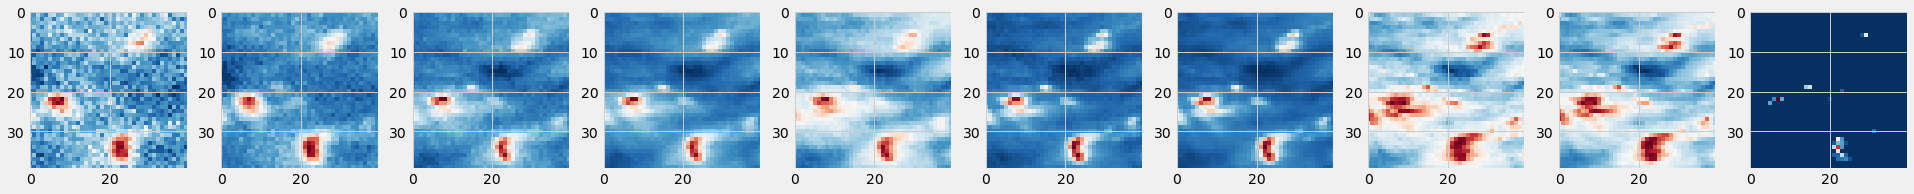

In [8]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:,:,i], cmap=color_map)
    
plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

# 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling

모델 구축

참고한 코드 [링크1](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) , [링크2](https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification)

In [18]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [10]:
model = Model(input_layer, output_layer)

In [11]:
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = y_pred.reshape(1, -1)[0] 
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0] 
    remove_NAs = y_true >= 0 
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0) 
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [12]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

# 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [13]:
model_history = model.fit(train_dataset, epochs = 30, verbose=1)

Epoch 1/30


     99/Unknown - 8s 8s/step - loss: 0.5633 - maeOverFscore_keras: 21.4225 - fscore_keras: 0.083 - 14s 7s/step - loss: 0.4975 - maeOverFscore_keras: 18.4032 - fscore_keras: 0.08 - 20s 7s/step - loss: 0.4605 - maeOverFscore_keras: 17.2657 - fscore_keras: 0.08 - 26s 6s/step - loss: 0.4335 - maeOverFscore_keras: 16.9326 - fscore_keras: 0.08 - 32s 6s/step - loss: 0.4057 - maeOverFscore_keras: 16.5502 - fscore_keras: 0.08 - 41s 7s/step - loss: 0.3868 - maeOverFscore_keras: 16.8364 - fscore_keras: 0.08 - 48s 7s/step - loss: 0.3673 - maeOverFscore_keras: 16.6793 - fscore_keras: 0.08 - 54s 7s/step - loss: 0.3484 - maeOverFscore_keras: 16.8532 - fscore_keras: 0.08 - 61s 7s/step - loss: 0.3342 - maeOverFscore_keras: 16.6509 - fscore_keras: 0.08 - 68s 7s/step - loss: 0.3214 - maeOverFscore_keras: 16.6367 - fscore_keras: 0.08 - 76s 7s/step - loss: 0.3126 - maeOverFscore_keras: 16.6870 - fscore_keras: 0.08 - 83s 7s/step - loss: 0.3021 - maeOverFscore_keras: 17.0465 - fscore_keras: 0.08 - 90s 7s/ste

150/150 [==============================].1914 - maeOverFscore_keras: 10.3971 - fscore_keras: 0.250 - 732s 7s/step - loss: 0.1907 - maeOverFscore_keras: 10.3318 - fscore_keras: 0.252 - 740s 7s/step - loss: 0.1899 - maeOverFscore_keras: 10.2752 - fscore_keras: 0.254 - 746s 7s/step - loss: 0.1890 - maeOverFscore_keras: 10.2184 - fscore_keras: 0.255 - 754s 7s/step - loss: 0.1883 - maeOverFscore_keras: 10.1602 - fscore_keras: 0.256 - 761s 7s/step - loss: 0.1874 - maeOverFscore_keras: 10.0999 - fscore_keras: 0.258 - 768s 7s/step - loss: 0.1865 - maeOverFscore_keras: 10.0414 - fscore_keras: 0.259 - 775s 7s/step - loss: 0.1854 - maeOverFscore_keras: 9.9893 - fscore_keras: 0.260 - 782s 7s/step - loss: 0.1847 - maeOverFscore_keras: 9.9451 - fscore_keras: 0.26 - 790s 7s/step - loss: 0.1836 - maeOverFscore_keras: 9.9075 - fscore_keras: 0.26 - 797s 7s/step - loss: 0.1829 - maeOverFscore_keras: 9.8638 - fscore_keras: 0.26 - 804s 7s/step - loss: 0.1822 - maeOverFscore_keras: 9.8178 - fscore_keras: 0.

103/150 [===================>..........] - ETA: 20:48 - loss: 0.0768 - maeOverFscore_keras: 4.9620 - fscore_keras: 0.321 - ETA: 19:31 - loss: 0.0674 - maeOverFscore_keras: 4.5725 - fscore_keras: 0.300 - ETA: 18:52 - loss: 0.0695 - maeOverFscore_keras: 4.5890 - fscore_keras: 0.295 - ETA: 18:19 - loss: 0.0735 - maeOverFscore_keras: 4.8274 - fscore_keras: 0.288 - ETA: 18:00 - loss: 0.0713 - maeOverFscore_keras: 4.6002 - fscore_keras: 0.295 - ETA: 17:43 - loss: 0.0732 - maeOverFscore_keras: 4.6179 - fscore_keras: 0.299 - ETA: 17:32 - loss: 0.0712 - maeOverFscore_keras: 4.3593 - fscore_keras: 0.316 - ETA: 17:19 - loss: 0.0684 - maeOverFscore_keras: 4.4809 - fscore_keras: 0.305 - ETA: 17:10 - loss: 0.0676 - maeOverFscore_keras: 4.4101 - fscore_keras: 0.306 - ETA: 17:00 - loss: 0.0663 - maeOverFscore_keras: 4.3250 - fscore_keras: 0.309 - ETA: 16:49 - loss: 0.0676 - maeOverFscore_keras: 4.2573 - fscore_keras: 0.319 - ETA: 16:30 - loss: 0.0666 - maeOverFscore_keras: 4.2259 - fscore_keras: 0.322

150/150 [==============================] - ETA: 5:24 - loss: 0.1244 - maeOverFscore_keras: 3.8839 - fscore_keras: 0.45 - ETA: 5:17 - loss: 0.1239 - maeOverFscore_keras: 3.8743 - fscore_keras: 0.45 - ETA: 5:10 - loss: 0.1236 - maeOverFscore_keras: 3.8640 - fscore_keras: 0.45 - ETA: 5:03 - loss: 0.1230 - maeOverFscore_keras: 3.8528 - fscore_keras: 0.45 - ETA: 4:56 - loss: 0.1227 - maeOverFscore_keras: 3.8518 - fscore_keras: 0.45 - ETA: 4:49 - loss: 0.1222 - maeOverFscore_keras: 3.8548 - fscore_keras: 0.45 - ETA: 4:42 - loss: 0.1220 - maeOverFscore_keras: 3.8587 - fscore_keras: 0.45 - ETA: 4:35 - loss: 0.1218 - maeOverFscore_keras: 3.8584 - fscore_keras: 0.45 - ETA: 4:28 - loss: 0.1213 - maeOverFscore_keras: 3.8523 - fscore_keras: 0.45 - ETA: 4:21 - loss: 0.1208 - maeOverFscore_keras: 3.8472 - fscore_keras: 0.45 - ETA: 4:14 - loss: 0.1206 - maeOverFscore_keras: 3.8379 - fscore_keras: 0.45 - ETA: 4:07 - loss: 0.1204 - maeOverFscore_keras: 3.8336 - fscore_keras: 0.45 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:27 - loss: 0.0695 - maeOverFscore_keras: 3.8882 - fscore_keras: 0.394 - ETA: 19:00 - loss: 0.0604 - maeOverFscore_keras: 3.6217 - fscore_keras: 0.367 - ETA: 18:24 - loss: 0.0622 - maeOverFscore_keras: 3.7392 - fscore_keras: 0.351 - ETA: 18:02 - loss: 0.0660 - maeOverFscore_keras: 3.9620 - fscore_keras: 0.340 - ETA: 17:51 - loss: 0.0639 - maeOverFscore_keras: 3.7070 - fscore_keras: 0.356 - ETA: 17:41 - loss: 0.0657 - maeOverFscore_keras: 3.6105 - fscore_keras: 0.371 - ETA: 17:31 - loss: 0.0641 - maeOverFscore_keras: 3.3803 - fscore_keras: 0.396 - ETA: 17:16 - loss: 0.0616 - maeOverFscore_keras: 3.3782 - fscore_keras: 0.388 - ETA: 17:04 - loss: 0.0610 - maeOverFscore_keras: 3.3248 - fscore_keras: 0.389 - ETA: 16:54 - loss: 0.0601 - maeOverFscore_keras: 3.2690 - fscore_keras: 0.393 - ETA: 16:46 - loss: 0.0615 - maeOverFscore_keras: 3.2166 - fscore_keras: 0.405 - ETA: 16:38 - loss: 0.0606 - maeOverFscore_keras: 3.1848 - fscore_keras: 0.410

150/150 [==============================] - ETA: 5:28 - loss: 0.1189 - maeOverFscore_keras: 3.3148 - fscore_keras: 0.51 - ETA: 5:20 - loss: 0.1185 - maeOverFscore_keras: 3.3092 - fscore_keras: 0.51 - ETA: 5:13 - loss: 0.1182 - maeOverFscore_keras: 3.3034 - fscore_keras: 0.51 - ETA: 5:06 - loss: 0.1176 - maeOverFscore_keras: 3.2996 - fscore_keras: 0.50 - ETA: 4:59 - loss: 0.1174 - maeOverFscore_keras: 3.3042 - fscore_keras: 0.50 - ETA: 4:52 - loss: 0.1169 - maeOverFscore_keras: 3.3078 - fscore_keras: 0.50 - ETA: 4:45 - loss: 0.1167 - maeOverFscore_keras: 3.3114 - fscore_keras: 0.50 - ETA: 4:38 - loss: 0.1164 - maeOverFscore_keras: 3.3121 - fscore_keras: 0.50 - ETA: 4:30 - loss: 0.1160 - maeOverFscore_keras: 3.3066 - fscore_keras: 0.50 - ETA: 4:23 - loss: 0.1156 - maeOverFscore_keras: 3.3032 - fscore_keras: 0.50 - ETA: 4:16 - loss: 0.1154 - maeOverFscore_keras: 3.2976 - fscore_keras: 0.50 - ETA: 4:09 - loss: 0.1152 - maeOverFscore_keras: 3.2962 - fscore_keras: 0.50 - ETA: 4:02 - loss: 0.1

103/150 [===================>..........] - ETA: 21:34 - loss: 0.0676 - maeOverFscore_keras: 3.2783 - fscore_keras: 0.454 - ETA: 19:44 - loss: 0.0584 - maeOverFscore_keras: 2.9226 - fscore_keras: 0.439 - ETA: 18:43 - loss: 0.0603 - maeOverFscore_keras: 3.0056 - fscore_keras: 0.421 - ETA: 18:15 - loss: 0.0645 - maeOverFscore_keras: 3.3141 - fscore_keras: 0.400 - ETA: 17:49 - loss: 0.0624 - maeOverFscore_keras: 3.1828 - fscore_keras: 0.403 - ETA: 17:31 - loss: 0.0645 - maeOverFscore_keras: 3.1946 - fscore_keras: 0.409 - ETA: 17:18 - loss: 0.0628 - maeOverFscore_keras: 3.0127 - fscore_keras: 0.429 - ETA: 17:04 - loss: 0.0604 - maeOverFscore_keras: 3.0227 - fscore_keras: 0.421 - ETA: 16:54 - loss: 0.0598 - maeOverFscore_keras: 2.9780 - fscore_keras: 0.422 - ETA: 16:47 - loss: 0.0587 - maeOverFscore_keras: 2.9170 - fscore_keras: 0.426 - ETA: 16:39 - loss: 0.0600 - maeOverFscore_keras: 2.8707 - fscore_keras: 0.439 - ETA: 16:31 - loss: 0.0591 - maeOverFscore_keras: 2.8531 - fscore_keras: 0.443

150/150 [==============================] - ETA: 5:25 - loss: 0.1172 - maeOverFscore_keras: 3.2274 - fscore_keras: 0.51 - ETA: 5:18 - loss: 0.1168 - maeOverFscore_keras: 3.2235 - fscore_keras: 0.51 - ETA: 5:11 - loss: 0.1165 - maeOverFscore_keras: 3.2182 - fscore_keras: 0.51 - ETA: 5:04 - loss: 0.1160 - maeOverFscore_keras: 3.2125 - fscore_keras: 0.51 - ETA: 4:57 - loss: 0.1157 - maeOverFscore_keras: 3.2115 - fscore_keras: 0.51 - ETA: 4:50 - loss: 0.1152 - maeOverFscore_keras: 3.2118 - fscore_keras: 0.51 - ETA: 4:43 - loss: 0.1150 - maeOverFscore_keras: 3.2105 - fscore_keras: 0.51 - ETA: 4:36 - loss: 0.1148 - maeOverFscore_keras: 3.2083 - fscore_keras: 0.51 - ETA: 4:29 - loss: 0.1143 - maeOverFscore_keras: 3.2021 - fscore_keras: 0.51 - ETA: 4:22 - loss: 0.1139 - maeOverFscore_keras: 3.1985 - fscore_keras: 0.51 - ETA: 4:15 - loss: 0.1137 - maeOverFscore_keras: 3.1930 - fscore_keras: 0.51 - ETA: 4:08 - loss: 0.1135 - maeOverFscore_keras: 3.1919 - fscore_keras: 0.51 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 20:59 - loss: 0.0669 - maeOverFscore_keras: 3.1605 - fscore_keras: 0.467 - ETA: 19:18 - loss: 0.0584 - maeOverFscore_keras: 2.8128 - fscore_keras: 0.458 - ETA: 18:39 - loss: 0.0599 - maeOverFscore_keras: 2.8095 - fscore_keras: 0.448 - ETA: 18:16 - loss: 0.0639 - maeOverFscore_keras: 3.0529 - fscore_keras: 0.428 - ETA: 18:01 - loss: 0.0618 - maeOverFscore_keras: 2.9290 - fscore_keras: 0.433 - ETA: 17:46 - loss: 0.0638 - maeOverFscore_keras: 2.9198 - fscore_keras: 0.442 - ETA: 17:31 - loss: 0.0620 - maeOverFscore_keras: 2.7611 - fscore_keras: 0.461 - ETA: 17:18 - loss: 0.0595 - maeOverFscore_keras: 2.7424 - fscore_keras: 0.455 - ETA: 17:07 - loss: 0.0588 - maeOverFscore_keras: 2.6786 - fscore_keras: 0.460 - ETA: 16:55 - loss: 0.0578 - maeOverFscore_keras: 2.6353 - fscore_keras: 0.464 - ETA: 16:44 - loss: 0.0590 - maeOverFscore_keras: 2.5901 - fscore_keras: 0.478 - ETA: 16:34 - loss: 0.0581 - maeOverFscore_keras: 2.5692 - fscore_keras: 0.483

150/150 [==============================] - ETA: 5:25 - loss: 0.1155 - maeOverFscore_keras: 3.0465 - fscore_keras: 0.53 - ETA: 5:18 - loss: 0.1151 - maeOverFscore_keras: 3.0414 - fscore_keras: 0.53 - ETA: 5:11 - loss: 0.1147 - maeOverFscore_keras: 3.0349 - fscore_keras: 0.53 - ETA: 5:04 - loss: 0.1142 - maeOverFscore_keras: 3.0292 - fscore_keras: 0.53 - ETA: 4:57 - loss: 0.1139 - maeOverFscore_keras: 3.0281 - fscore_keras: 0.53 - ETA: 4:50 - loss: 0.1134 - maeOverFscore_keras: 3.0276 - fscore_keras: 0.53 - ETA: 4:42 - loss: 0.1133 - maeOverFscore_keras: 3.0268 - fscore_keras: 0.53 - ETA: 4:35 - loss: 0.1130 - maeOverFscore_keras: 3.0237 - fscore_keras: 0.53 - ETA: 4:28 - loss: 0.1125 - maeOverFscore_keras: 3.0169 - fscore_keras: 0.53 - ETA: 4:21 - loss: 0.1121 - maeOverFscore_keras: 3.0127 - fscore_keras: 0.53 - ETA: 4:14 - loss: 0.1119 - maeOverFscore_keras: 3.0082 - fscore_keras: 0.53 - ETA: 4:07 - loss: 0.1118 - maeOverFscore_keras: 3.0086 - fscore_keras: 0.53 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:44 - loss: 0.0686 - maeOverFscore_keras: 3.1769 - fscore_keras: 0.464 - ETA: 19:23 - loss: 0.0603 - maeOverFscore_keras: 2.9326 - fscore_keras: 0.435 - ETA: 18:28 - loss: 0.0621 - maeOverFscore_keras: 3.0859 - fscore_keras: 0.411 - ETA: 18:09 - loss: 0.0661 - maeOverFscore_keras: 3.3626 - fscore_keras: 0.392 - ETA: 17:56 - loss: 0.0640 - maeOverFscore_keras: 3.2467 - fscore_keras: 0.394 - ETA: 17:42 - loss: 0.0656 - maeOverFscore_keras: 3.2789 - fscore_keras: 0.396 - ETA: 17:34 - loss: 0.0639 - maeOverFscore_keras: 3.1022 - fscore_keras: 0.415 - ETA: 17:18 - loss: 0.0614 - maeOverFscore_keras: 3.1556 - fscore_keras: 0.403 - ETA: 17:07 - loss: 0.0608 - maeOverFscore_keras: 3.1319 - fscore_keras: 0.401 - ETA: 16:55 - loss: 0.0597 - maeOverFscore_keras: 3.0984 - fscore_keras: 0.402 - ETA: 16:45 - loss: 0.0610 - maeOverFscore_keras: 3.0697 - fscore_keras: 0.411 - ETA: 16:35 - loss: 0.0601 - maeOverFscore_keras: 3.0419 - fscore_keras: 0.417

150/150 [==============================] - ETA: 5:26 - loss: 0.1160 - maeOverFscore_keras: 3.2334 - fscore_keras: 0.51 - ETA: 5:19 - loss: 0.1155 - maeOverFscore_keras: 3.2257 - fscore_keras: 0.51 - ETA: 5:11 - loss: 0.1152 - maeOverFscore_keras: 3.2174 - fscore_keras: 0.51 - ETA: 5:04 - loss: 0.1147 - maeOverFscore_keras: 3.2098 - fscore_keras: 0.51 - ETA: 4:57 - loss: 0.1144 - maeOverFscore_keras: 3.2093 - fscore_keras: 0.51 - ETA: 4:50 - loss: 0.1139 - maeOverFscore_keras: 3.2072 - fscore_keras: 0.51 - ETA: 4:43 - loss: 0.1137 - maeOverFscore_keras: 3.2053 - fscore_keras: 0.51 - ETA: 4:36 - loss: 0.1134 - maeOverFscore_keras: 3.2014 - fscore_keras: 0.51 - ETA: 4:29 - loss: 0.1129 - maeOverFscore_keras: 3.1938 - fscore_keras: 0.51 - ETA: 4:22 - loss: 0.1125 - maeOverFscore_keras: 3.1879 - fscore_keras: 0.51 - ETA: 4:15 - loss: 0.1123 - maeOverFscore_keras: 3.1813 - fscore_keras: 0.51 - ETA: 4:07 - loss: 0.1121 - maeOverFscore_keras: 3.1785 - fscore_keras: 0.51 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:16 - loss: 0.0651 - maeOverFscore_keras: 3.1145 - fscore_keras: 0.456 - ETA: 18:50 - loss: 0.0569 - maeOverFscore_keras: 2.8790 - fscore_keras: 0.431 - ETA: 18:10 - loss: 0.0589 - maeOverFscore_keras: 3.0396 - fscore_keras: 0.406 - ETA: 17:47 - loss: 0.0630 - maeOverFscore_keras: 3.3052 - fscore_keras: 0.389 - ETA: 17:34 - loss: 0.0609 - maeOverFscore_keras: 3.1485 - fscore_keras: 0.398 - ETA: 17:19 - loss: 0.0627 - maeOverFscore_keras: 3.1261 - fscore_keras: 0.406 - ETA: 17:07 - loss: 0.0610 - maeOverFscore_keras: 2.9377 - fscore_keras: 0.430 - ETA: 16:57 - loss: 0.0588 - maeOverFscore_keras: 2.9453 - fscore_keras: 0.423 - ETA: 16:49 - loss: 0.0581 - maeOverFscore_keras: 2.9006 - fscore_keras: 0.423 - ETA: 16:45 - loss: 0.0571 - maeOverFscore_keras: 2.8465 - fscore_keras: 0.427 - ETA: 16:35 - loss: 0.0585 - maeOverFscore_keras: 2.8301 - fscore_keras: 0.435 - ETA: 16:26 - loss: 0.0576 - maeOverFscore_keras: 2.8200 - fscore_keras: 0.438

150/150 [==============================] - ETA: 5:25 - loss: 0.1123 - maeOverFscore_keras: 2.8921 - fscore_keras: 0.55 - ETA: 5:18 - loss: 0.1119 - maeOverFscore_keras: 2.8860 - fscore_keras: 0.55 - ETA: 5:11 - loss: 0.1116 - maeOverFscore_keras: 2.8790 - fscore_keras: 0.55 - ETA: 5:04 - loss: 0.1111 - maeOverFscore_keras: 2.8718 - fscore_keras: 0.55 - ETA: 4:57 - loss: 0.1108 - maeOverFscore_keras: 2.8713 - fscore_keras: 0.55 - ETA: 4:50 - loss: 0.1103 - maeOverFscore_keras: 2.8706 - fscore_keras: 0.55 - ETA: 4:43 - loss: 0.1101 - maeOverFscore_keras: 2.8709 - fscore_keras: 0.55 - ETA: 4:36 - loss: 0.1099 - maeOverFscore_keras: 2.8691 - fscore_keras: 0.55 - ETA: 4:28 - loss: 0.1094 - maeOverFscore_keras: 2.8634 - fscore_keras: 0.55 - ETA: 4:21 - loss: 0.1090 - maeOverFscore_keras: 2.8587 - fscore_keras: 0.55 - ETA: 4:14 - loss: 0.1088 - maeOverFscore_keras: 2.8526 - fscore_keras: 0.55 - ETA: 4:07 - loss: 0.1086 - maeOverFscore_keras: 2.8510 - fscore_keras: 0.55 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:23 - loss: 0.0640 - maeOverFscore_keras: 2.8711 - fscore_keras: 0.491 - ETA: 18:50 - loss: 0.0558 - maeOverFscore_keras: 2.6100 - fscore_keras: 0.471 - ETA: 18:11 - loss: 0.0575 - maeOverFscore_keras: 2.6059 - fscore_keras: 0.463 - ETA: 17:52 - loss: 0.0614 - maeOverFscore_keras: 2.7771 - fscore_keras: 0.450 - ETA: 17:33 - loss: 0.0595 - maeOverFscore_keras: 2.6394 - fscore_keras: 0.460 - ETA: 17:22 - loss: 0.0611 - maeOverFscore_keras: 2.6040 - fscore_keras: 0.471 - ETA: 17:12 - loss: 0.0594 - maeOverFscore_keras: 2.4687 - fscore_keras: 0.491 - ETA: 17:02 - loss: 0.0571 - maeOverFscore_keras: 2.4814 - fscore_keras: 0.481 - ETA: 16:55 - loss: 0.0564 - maeOverFscore_keras: 2.4502 - fscore_keras: 0.481 - ETA: 16:43 - loss: 0.0555 - maeOverFscore_keras: 2.4221 - fscore_keras: 0.482 - ETA: 16:35 - loss: 0.0565 - maeOverFscore_keras: 2.3887 - fscore_keras: 0.495 - ETA: 16:28 - loss: 0.0558 - maeOverFscore_keras: 2.3762 - fscore_keras: 0.499

150/150 [==============================] - ETA: 5:26 - loss: 0.1108 - maeOverFscore_keras: 2.7382 - fscore_keras: 0.57 - ETA: 5:18 - loss: 0.1105 - maeOverFscore_keras: 2.7348 - fscore_keras: 0.57 - ETA: 5:11 - loss: 0.1101 - maeOverFscore_keras: 2.7315 - fscore_keras: 0.57 - ETA: 5:04 - loss: 0.1097 - maeOverFscore_keras: 2.7266 - fscore_keras: 0.57 - ETA: 4:57 - loss: 0.1094 - maeOverFscore_keras: 2.7261 - fscore_keras: 0.57 - ETA: 4:50 - loss: 0.1089 - maeOverFscore_keras: 2.7251 - fscore_keras: 0.57 - ETA: 4:43 - loss: 0.1088 - maeOverFscore_keras: 2.7233 - fscore_keras: 0.57 - ETA: 4:36 - loss: 0.1085 - maeOverFscore_keras: 2.7215 - fscore_keras: 0.57 - ETA: 4:29 - loss: 0.1081 - maeOverFscore_keras: 2.7170 - fscore_keras: 0.57 - ETA: 4:22 - loss: 0.1077 - maeOverFscore_keras: 2.7149 - fscore_keras: 0.57 - ETA: 4:14 - loss: 0.1075 - maeOverFscore_keras: 2.7114 - fscore_keras: 0.57 - ETA: 4:07 - loss: 0.1074 - maeOverFscore_keras: 2.7110 - fscore_keras: 0.57 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:31 - loss: 0.0635 - maeOverFscore_keras: 2.8767 - fscore_keras: 0.484 - ETA: 18:53 - loss: 0.0561 - maeOverFscore_keras: 2.7311 - fscore_keras: 0.455 - ETA: 18:23 - loss: 0.0586 - maeOverFscore_keras: 2.8761 - fscore_keras: 0.432 - ETA: 17:58 - loss: 0.0625 - maeOverFscore_keras: 3.1425 - fscore_keras: 0.411 - ETA: 17:40 - loss: 0.0605 - maeOverFscore_keras: 3.0065 - fscore_keras: 0.418 - ETA: 17:28 - loss: 0.0621 - maeOverFscore_keras: 2.9477 - fscore_keras: 0.431 - ETA: 17:16 - loss: 0.0602 - maeOverFscore_keras: 2.7648 - fscore_keras: 0.456 - ETA: 17:05 - loss: 0.0578 - maeOverFscore_keras: 2.7111 - fscore_keras: 0.454 - ETA: 16:58 - loss: 0.0572 - maeOverFscore_keras: 2.6227 - fscore_keras: 0.464 - ETA: 16:48 - loss: 0.0561 - maeOverFscore_keras: 2.5405 - fscore_keras: 0.474 - ETA: 16:40 - loss: 0.0569 - maeOverFscore_keras: 2.4736 - fscore_keras: 0.492 - ETA: 16:30 - loss: 0.0561 - maeOverFscore_keras: 2.4554 - fscore_keras: 0.496

150/150 [==============================] - ETA: 5:24 - loss: 0.1103 - maeOverFscore_keras: 2.7221 - fscore_keras: 0.57 - ETA: 5:17 - loss: 0.1099 - maeOverFscore_keras: 2.7173 - fscore_keras: 0.57 - ETA: 5:10 - loss: 0.1096 - maeOverFscore_keras: 2.7121 - fscore_keras: 0.57 - ETA: 5:03 - loss: 0.1091 - maeOverFscore_keras: 2.7068 - fscore_keras: 0.57 - ETA: 4:56 - loss: 0.1088 - maeOverFscore_keras: 2.7065 - fscore_keras: 0.57 - ETA: 4:49 - loss: 0.1083 - maeOverFscore_keras: 2.7056 - fscore_keras: 0.57 - ETA: 4:42 - loss: 0.1082 - maeOverFscore_keras: 2.7037 - fscore_keras: 0.57 - ETA: 4:35 - loss: 0.1079 - maeOverFscore_keras: 2.7005 - fscore_keras: 0.57 - ETA: 4:28 - loss: 0.1074 - maeOverFscore_keras: 2.6945 - fscore_keras: 0.57 - ETA: 4:21 - loss: 0.1070 - maeOverFscore_keras: 2.6904 - fscore_keras: 0.57 - ETA: 4:14 - loss: 0.1069 - maeOverFscore_keras: 2.6851 - fscore_keras: 0.57 - ETA: 4:07 - loss: 0.1067 - maeOverFscore_keras: 2.6845 - fscore_keras: 0.57 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:33 - loss: 0.0643 - maeOverFscore_keras: 2.8405 - fscore_keras: 0.488 - ETA: 19:03 - loss: 0.0556 - maeOverFscore_keras: 2.5554 - fscore_keras: 0.469 - ETA: 18:39 - loss: 0.0569 - maeOverFscore_keras: 2.4905 - fscore_keras: 0.473 - ETA: 18:21 - loss: 0.0604 - maeOverFscore_keras: 2.5918 - fscore_keras: 0.467 - ETA: 18:01 - loss: 0.0587 - maeOverFscore_keras: 2.4613 - fscore_keras: 0.480 - ETA: 17:48 - loss: 0.0600 - maeOverFscore_keras: 2.4157 - fscore_keras: 0.493 - ETA: 17:35 - loss: 0.0584 - maeOverFscore_keras: 2.2999 - fscore_keras: 0.512 - ETA: 17:19 - loss: 0.0562 - maeOverFscore_keras: 2.3168 - fscore_keras: 0.502 - ETA: 17:09 - loss: 0.0555 - maeOverFscore_keras: 2.2742 - fscore_keras: 0.506 - ETA: 17:00 - loss: 0.0545 - maeOverFscore_keras: 2.2423 - fscore_keras: 0.508 - ETA: 16:51 - loss: 0.0555 - maeOverFscore_keras: 2.2058 - fscore_keras: 0.523 - ETA: 16:43 - loss: 0.0547 - maeOverFscore_keras: 2.1893 - fscore_keras: 0.528

150/150 [==============================] - ETA: 5:25 - loss: 0.1085 - maeOverFscore_keras: 2.5548 - fscore_keras: 0.59 - ETA: 5:18 - loss: 0.1081 - maeOverFscore_keras: 2.5501 - fscore_keras: 0.59 - ETA: 5:11 - loss: 0.1078 - maeOverFscore_keras: 2.5449 - fscore_keras: 0.59 - ETA: 5:04 - loss: 0.1073 - maeOverFscore_keras: 2.5394 - fscore_keras: 0.59 - ETA: 4:57 - loss: 0.1070 - maeOverFscore_keras: 2.5397 - fscore_keras: 0.59 - ETA: 4:50 - loss: 0.1065 - maeOverFscore_keras: 2.5411 - fscore_keras: 0.59 - ETA: 4:43 - loss: 0.1064 - maeOverFscore_keras: 2.5410 - fscore_keras: 0.59 - ETA: 4:36 - loss: 0.1061 - maeOverFscore_keras: 2.5401 - fscore_keras: 0.59 - ETA: 4:29 - loss: 0.1057 - maeOverFscore_keras: 2.5354 - fscore_keras: 0.59 - ETA: 4:22 - loss: 0.1053 - maeOverFscore_keras: 2.5317 - fscore_keras: 0.59 - ETA: 4:15 - loss: 0.1051 - maeOverFscore_keras: 2.5267 - fscore_keras: 0.59 - ETA: 4:07 - loss: 0.1050 - maeOverFscore_keras: 2.5262 - fscore_keras: 0.59 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:14 - loss: 0.0629 - maeOverFscore_keras: 2.8201 - fscore_keras: 0.493 - ETA: 18:47 - loss: 0.0547 - maeOverFscore_keras: 2.5920 - fscore_keras: 0.467 - ETA: 18:15 - loss: 0.0563 - maeOverFscore_keras: 2.5820 - fscore_keras: 0.461 - ETA: 17:52 - loss: 0.0602 - maeOverFscore_keras: 2.7104 - fscore_keras: 0.452 - ETA: 17:41 - loss: 0.0584 - maeOverFscore_keras: 2.5470 - fscore_keras: 0.469 - ETA: 17:25 - loss: 0.0596 - maeOverFscore_keras: 2.4751 - fscore_keras: 0.487 - ETA: 17:13 - loss: 0.0583 - maeOverFscore_keras: 2.3502 - fscore_keras: 0.508 - ETA: 17:04 - loss: 0.0561 - maeOverFscore_keras: 2.3536 - fscore_keras: 0.500 - ETA: 16:54 - loss: 0.0554 - maeOverFscore_keras: 2.3092 - fscore_keras: 0.503 - ETA: 16:46 - loss: 0.0544 - maeOverFscore_keras: 2.2810 - fscore_keras: 0.504 - ETA: 16:38 - loss: 0.0555 - maeOverFscore_keras: 2.2515 - fscore_keras: 0.517 - ETA: 16:29 - loss: 0.0547 - maeOverFscore_keras: 2.2381 - fscore_keras: 0.521

150/150 [==============================] - ETA: 5:25 - loss: 0.1262 - maeOverFscore_keras: 3.8861 - fscore_keras: 0.47 - ETA: 5:18 - loss: 0.1258 - maeOverFscore_keras: 3.8765 - fscore_keras: 0.47 - ETA: 5:11 - loss: 0.1255 - maeOverFscore_keras: 3.8655 - fscore_keras: 0.47 - ETA: 5:03 - loss: 0.1249 - maeOverFscore_keras: 3.8567 - fscore_keras: 0.47 - ETA: 4:56 - loss: 0.1246 - maeOverFscore_keras: 3.8547 - fscore_keras: 0.47 - ETA: 4:49 - loss: 0.1241 - maeOverFscore_keras: 3.8532 - fscore_keras: 0.47 - ETA: 4:42 - loss: 0.1239 - maeOverFscore_keras: 3.8529 - fscore_keras: 0.47 - ETA: 4:35 - loss: 0.1236 - maeOverFscore_keras: 3.8529 - fscore_keras: 0.47 - ETA: 4:28 - loss: 0.1232 - maeOverFscore_keras: 3.8501 - fscore_keras: 0.47 - ETA: 4:21 - loss: 0.1227 - maeOverFscore_keras: 3.8496 - fscore_keras: 0.47 - ETA: 4:14 - loss: 0.1225 - maeOverFscore_keras: 3.8460 - fscore_keras: 0.47 - ETA: 4:07 - loss: 0.1223 - maeOverFscore_keras: 3.8448 - fscore_keras: 0.47 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:31 - loss: 0.0725 - maeOverFscore_keras: 4.3023 - fscore_keras: 0.375 - ETA: 18:50 - loss: 0.0619 - maeOverFscore_keras: 3.8819 - fscore_keras: 0.356 - ETA: 18:25 - loss: 0.0636 - maeOverFscore_keras: 4.1015 - fscore_keras: 0.333 - ETA: 18:01 - loss: 0.0676 - maeOverFscore_keras: 4.5232 - fscore_keras: 0.314 - ETA: 17:38 - loss: 0.0656 - maeOverFscore_keras: 4.3786 - fscore_keras: 0.315 - ETA: 17:26 - loss: 0.0676 - maeOverFscore_keras: 4.3631 - fscore_keras: 0.321 - ETA: 17:15 - loss: 0.0657 - maeOverFscore_keras: 4.0941 - fscore_keras: 0.341 - ETA: 17:05 - loss: 0.0629 - maeOverFscore_keras: 4.0519 - fscore_keras: 0.337 - ETA: 16:55 - loss: 0.0622 - maeOverFscore_keras: 3.9119 - fscore_keras: 0.346 - ETA: 16:45 - loss: 0.0611 - maeOverFscore_keras: 3.7576 - fscore_keras: 0.360 - ETA: 16:37 - loss: 0.0623 - maeOverFscore_keras: 3.6292 - fscore_keras: 0.381 - ETA: 16:27 - loss: 0.0614 - maeOverFscore_keras: 3.5439 - fscore_keras: 0.392

150/150 [==============================] - ETA: 5:25 - loss: 0.1198 - maeOverFscore_keras: 3.3314 - fscore_keras: 0.51 - ETA: 5:18 - loss: 0.1194 - maeOverFscore_keras: 3.3237 - fscore_keras: 0.51 - ETA: 5:11 - loss: 0.1190 - maeOverFscore_keras: 3.3139 - fscore_keras: 0.51 - ETA: 5:04 - loss: 0.1184 - maeOverFscore_keras: 3.3049 - fscore_keras: 0.51 - ETA: 4:57 - loss: 0.1181 - maeOverFscore_keras: 3.3009 - fscore_keras: 0.51 - ETA: 4:50 - loss: 0.1176 - maeOverFscore_keras: 3.2986 - fscore_keras: 0.51 - ETA: 4:43 - loss: 0.1174 - maeOverFscore_keras: 3.2953 - fscore_keras: 0.51 - ETA: 4:35 - loss: 0.1171 - maeOverFscore_keras: 3.2914 - fscore_keras: 0.51 - ETA: 4:28 - loss: 0.1166 - maeOverFscore_keras: 3.2836 - fscore_keras: 0.51 - ETA: 4:21 - loss: 0.1161 - maeOverFscore_keras: 3.2774 - fscore_keras: 0.51 - ETA: 4:14 - loss: 0.1159 - maeOverFscore_keras: 3.2697 - fscore_keras: 0.51 - ETA: 4:07 - loss: 0.1157 - maeOverFscore_keras: 3.2667 - fscore_keras: 0.51 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:41 - loss: 0.0656 - maeOverFscore_keras: 3.2689 - fscore_keras: 0.446 - ETA: 19:12 - loss: 0.0579 - maeOverFscore_keras: 2.9865 - fscore_keras: 0.429 - ETA: 18:23 - loss: 0.0592 - maeOverFscore_keras: 2.8734 - fscore_keras: 0.434 - ETA: 18:00 - loss: 0.0628 - maeOverFscore_keras: 2.9741 - fscore_keras: 0.429 - ETA: 17:43 - loss: 0.0608 - maeOverFscore_keras: 2.7985 - fscore_keras: 0.444 - ETA: 17:25 - loss: 0.0623 - maeOverFscore_keras: 2.7012 - fscore_keras: 0.465 - ETA: 17:17 - loss: 0.0607 - maeOverFscore_keras: 2.5585 - fscore_keras: 0.485 - ETA: 17:07 - loss: 0.0584 - maeOverFscore_keras: 2.5538 - fscore_keras: 0.478 - ETA: 16:56 - loss: 0.0577 - maeOverFscore_keras: 2.5120 - fscore_keras: 0.480 - ETA: 16:49 - loss: 0.0567 - maeOverFscore_keras: 2.4934 - fscore_keras: 0.479 - ETA: 16:41 - loss: 0.0577 - maeOverFscore_keras: 2.4526 - fscore_keras: 0.493 - ETA: 16:33 - loss: 0.0568 - maeOverFscore_keras: 2.4362 - fscore_keras: 0.497

150/150 [==============================] - ETA: 5:26 - loss: 0.1119 - maeOverFscore_keras: 2.7700 - fscore_keras: 0.57 - ETA: 5:19 - loss: 0.1115 - maeOverFscore_keras: 2.7645 - fscore_keras: 0.57 - ETA: 5:12 - loss: 0.1112 - maeOverFscore_keras: 2.7581 - fscore_keras: 0.57 - ETA: 5:05 - loss: 0.1107 - maeOverFscore_keras: 2.7520 - fscore_keras: 0.57 - ETA: 4:58 - loss: 0.1104 - maeOverFscore_keras: 2.7510 - fscore_keras: 0.57 - ETA: 4:50 - loss: 0.1099 - maeOverFscore_keras: 2.7501 - fscore_keras: 0.57 - ETA: 4:43 - loss: 0.1097 - maeOverFscore_keras: 2.7493 - fscore_keras: 0.57 - ETA: 4:36 - loss: 0.1094 - maeOverFscore_keras: 2.7470 - fscore_keras: 0.57 - ETA: 4:29 - loss: 0.1090 - maeOverFscore_keras: 2.7416 - fscore_keras: 0.57 - ETA: 4:22 - loss: 0.1086 - maeOverFscore_keras: 2.7376 - fscore_keras: 0.57 - ETA: 4:15 - loss: 0.1084 - maeOverFscore_keras: 2.7317 - fscore_keras: 0.57 - ETA: 4:08 - loss: 0.1082 - maeOverFscore_keras: 2.7304 - fscore_keras: 0.57 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 20:20 - loss: 0.0622 - maeOverFscore_keras: 2.6698 - fscore_keras: 0.510 - ETA: 18:51 - loss: 0.0548 - maeOverFscore_keras: 2.4567 - fscore_keras: 0.487 - ETA: 18:20 - loss: 0.0564 - maeOverFscore_keras: 2.4266 - fscore_keras: 0.484 - ETA: 17:58 - loss: 0.0601 - maeOverFscore_keras: 2.5739 - fscore_keras: 0.472 - ETA: 17:43 - loss: 0.0583 - maeOverFscore_keras: 2.4735 - fscore_keras: 0.478 - ETA: 17:32 - loss: 0.0598 - maeOverFscore_keras: 2.4377 - fscore_keras: 0.490 - ETA: 17:19 - loss: 0.0583 - maeOverFscore_keras: 2.3166 - fscore_keras: 0.510 - ETA: 17:09 - loss: 0.0561 - maeOverFscore_keras: 2.3164 - fscore_keras: 0.503 - ETA: 16:57 - loss: 0.0554 - maeOverFscore_keras: 2.2681 - fscore_keras: 0.508 - ETA: 16:49 - loss: 0.0544 - maeOverFscore_keras: 2.2261 - fscore_keras: 0.512 - ETA: 16:39 - loss: 0.0552 - maeOverFscore_keras: 2.1820 - fscore_keras: 0.528 - ETA: 16:30 - loss: 0.0545 - maeOverFscore_keras: 2.1692 - fscore_keras: 0.533

150/150 [==============================] - ETA: 5:25 - loss: 0.1093 - maeOverFscore_keras: 2.6181 - fscore_keras: 0.59 - ETA: 5:18 - loss: 0.1090 - maeOverFscore_keras: 2.6130 - fscore_keras: 0.59 - ETA: 5:11 - loss: 0.1086 - maeOverFscore_keras: 2.6075 - fscore_keras: 0.59 - ETA: 5:04 - loss: 0.1081 - maeOverFscore_keras: 2.6015 - fscore_keras: 0.59 - ETA: 4:57 - loss: 0.1079 - maeOverFscore_keras: 2.6007 - fscore_keras: 0.59 - ETA: 4:50 - loss: 0.1074 - maeOverFscore_keras: 2.5997 - fscore_keras: 0.59 - ETA: 4:43 - loss: 0.1072 - maeOverFscore_keras: 2.5985 - fscore_keras: 0.59 - ETA: 4:36 - loss: 0.1069 - maeOverFscore_keras: 2.5961 - fscore_keras: 0.59 - ETA: 4:29 - loss: 0.1065 - maeOverFscore_keras: 2.5907 - fscore_keras: 0.59 - ETA: 4:22 - loss: 0.1061 - maeOverFscore_keras: 2.5872 - fscore_keras: 0.59 - ETA: 4:14 - loss: 0.1059 - maeOverFscore_keras: 2.5819 - fscore_keras: 0.59 - ETA: 4:07 - loss: 0.1057 - maeOverFscore_keras: 2.5811 - fscore_keras: 0.59 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 21:07 - loss: 0.0617 - maeOverFscore_keras: 2.5502 - fscore_keras: 0.530 - ETA: 19:19 - loss: 0.0542 - maeOverFscore_keras: 2.3459 - fscore_keras: 0.508 - ETA: 18:31 - loss: 0.0560 - maeOverFscore_keras: 2.3547 - fscore_keras: 0.499 - ETA: 18:04 - loss: 0.0599 - maeOverFscore_keras: 2.5199 - fscore_keras: 0.483 - ETA: 17:46 - loss: 0.0583 - maeOverFscore_keras: 2.4202 - fscore_keras: 0.490 - ETA: 17:35 - loss: 0.0599 - maeOverFscore_keras: 2.4096 - fscore_keras: 0.498 - ETA: 17:22 - loss: 0.0581 - maeOverFscore_keras: 2.2914 - fscore_keras: 0.515 - ETA: 17:10 - loss: 0.0560 - maeOverFscore_keras: 2.3205 - fscore_keras: 0.503 - ETA: 17:00 - loss: 0.0555 - maeOverFscore_keras: 2.2936 - fscore_keras: 0.503 - ETA: 16:48 - loss: 0.0545 - maeOverFscore_keras: 2.2483 - fscore_keras: 0.508 - ETA: 16:37 - loss: 0.0552 - maeOverFscore_keras: 2.2066 - fscore_keras: 0.522 - ETA: 16:29 - loss: 0.0544 - maeOverFscore_keras: 2.1951 - fscore_keras: 0.526

150/150 [==============================] - ETA: 5:25 - loss: 0.1086 - maeOverFscore_keras: 2.5745 - fscore_keras: 0.59 - ETA: 5:18 - loss: 0.1082 - maeOverFscore_keras: 2.5699 - fscore_keras: 0.59 - ETA: 5:11 - loss: 0.1079 - maeOverFscore_keras: 2.5650 - fscore_keras: 0.59 - ETA: 5:04 - loss: 0.1074 - maeOverFscore_keras: 2.5595 - fscore_keras: 0.59 - ETA: 4:57 - loss: 0.1071 - maeOverFscore_keras: 2.5587 - fscore_keras: 0.59 - ETA: 4:50 - loss: 0.1066 - maeOverFscore_keras: 2.5575 - fscore_keras: 0.59 - ETA: 4:43 - loss: 0.1065 - maeOverFscore_keras: 2.5553 - fscore_keras: 0.59 - ETA: 4:36 - loss: 0.1062 - maeOverFscore_keras: 2.5527 - fscore_keras: 0.59 - ETA: 4:29 - loss: 0.1058 - maeOverFscore_keras: 2.5474 - fscore_keras: 0.59 - ETA: 4:22 - loss: 0.1054 - maeOverFscore_keras: 2.5441 - fscore_keras: 0.59 - ETA: 4:15 - loss: 0.1052 - maeOverFscore_keras: 2.5390 - fscore_keras: 0.59 - ETA: 4:08 - loss: 0.1050 - maeOverFscore_keras: 2.5382 - fscore_keras: 0.59 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 20:43 - loss: 0.0615 - maeOverFscore_keras: 2.4768 - fscore_keras: 0.537 - ETA: 18:56 - loss: 0.0546 - maeOverFscore_keras: 2.2472 - fscore_keras: 0.519 - ETA: 18:11 - loss: 0.0557 - maeOverFscore_keras: 2.1808 - fscore_keras: 0.521 - ETA: 17:45 - loss: 0.0594 - maeOverFscore_keras: 2.3240 - fscore_keras: 0.507 - ETA: 17:30 - loss: 0.0576 - maeOverFscore_keras: 2.2505 - fscore_keras: 0.510 - ETA: 17:20 - loss: 0.0591 - maeOverFscore_keras: 2.2504 - fscore_keras: 0.518 - ETA: 17:09 - loss: 0.0575 - maeOverFscore_keras: 2.1549 - fscore_keras: 0.533 - ETA: 16:57 - loss: 0.0552 - maeOverFscore_keras: 2.1564 - fscore_keras: 0.525 - ETA: 16:49 - loss: 0.0546 - maeOverFscore_keras: 2.1133 - fscore_keras: 0.530 - ETA: 16:41 - loss: 0.0536 - maeOverFscore_keras: 2.0767 - fscore_keras: 0.534 - ETA: 16:31 - loss: 0.0544 - maeOverFscore_keras: 2.0357 - fscore_keras: 0.550 - ETA: 16:24 - loss: 0.0537 - maeOverFscore_keras: 2.0297 - fscore_keras: 0.553

150/150 [==============================] - ETA: 5:27 - loss: 0.1080 - maeOverFscore_keras: 2.5242 - fscore_keras: 0.60 - ETA: 5:19 - loss: 0.1076 - maeOverFscore_keras: 2.5198 - fscore_keras: 0.60 - ETA: 5:12 - loss: 0.1073 - maeOverFscore_keras: 2.5148 - fscore_keras: 0.60 - ETA: 5:05 - loss: 0.1068 - maeOverFscore_keras: 2.5093 - fscore_keras: 0.60 - ETA: 4:58 - loss: 0.1065 - maeOverFscore_keras: 2.5092 - fscore_keras: 0.60 - ETA: 4:51 - loss: 0.1061 - maeOverFscore_keras: 2.5089 - fscore_keras: 0.60 - ETA: 4:44 - loss: 0.1059 - maeOverFscore_keras: 2.5077 - fscore_keras: 0.60 - ETA: 4:37 - loss: 0.1056 - maeOverFscore_keras: 2.5057 - fscore_keras: 0.60 - ETA: 4:30 - loss: 0.1052 - maeOverFscore_keras: 2.5009 - fscore_keras: 0.60 - ETA: 4:22 - loss: 0.1048 - maeOverFscore_keras: 2.4982 - fscore_keras: 0.60 - ETA: 4:15 - loss: 0.1046 - maeOverFscore_keras: 2.4936 - fscore_keras: 0.60 - ETA: 4:08 - loss: 0.1045 - maeOverFscore_keras: 2.4935 - fscore_keras: 0.60 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 20:57 - loss: 0.0607 - maeOverFscore_keras: 2.4460 - fscore_keras: 0.541 - ETA: 19:10 - loss: 0.0534 - maeOverFscore_keras: 2.2288 - fscore_keras: 0.522 - ETA: 18:31 - loss: 0.0548 - maeOverFscore_keras: 2.1803 - fscore_keras: 0.523 - ETA: 18:08 - loss: 0.0588 - maeOverFscore_keras: 2.3252 - fscore_keras: 0.509 - ETA: 17:48 - loss: 0.0572 - maeOverFscore_keras: 2.2489 - fscore_keras: 0.512 - ETA: 17:32 - loss: 0.0588 - maeOverFscore_keras: 2.2283 - fscore_keras: 0.523 - ETA: 17:19 - loss: 0.0570 - maeOverFscore_keras: 2.1306 - fscore_keras: 0.537 - ETA: 17:08 - loss: 0.0548 - maeOverFscore_keras: 2.1439 - fscore_keras: 0.528 - ETA: 16:58 - loss: 0.0541 - maeOverFscore_keras: 2.1033 - fscore_keras: 0.531 - ETA: 16:48 - loss: 0.0532 - maeOverFscore_keras: 2.0698 - fscore_keras: 0.534 - ETA: 16:40 - loss: 0.0538 - maeOverFscore_keras: 2.0231 - fscore_keras: 0.551 - ETA: 16:31 - loss: 0.0531 - maeOverFscore_keras: 2.0210 - fscore_keras: 0.554

150/150 [==============================] - ETA: 5:26 - loss: 0.1079 - maeOverFscore_keras: 2.5286 - fscore_keras: 0.60 - ETA: 5:19 - loss: 0.1076 - maeOverFscore_keras: 2.5244 - fscore_keras: 0.60 - ETA: 5:12 - loss: 0.1072 - maeOverFscore_keras: 2.5197 - fscore_keras: 0.60 - ETA: 5:05 - loss: 0.1067 - maeOverFscore_keras: 2.5136 - fscore_keras: 0.60 - ETA: 4:58 - loss: 0.1065 - maeOverFscore_keras: 2.5126 - fscore_keras: 0.60 - ETA: 4:50 - loss: 0.1060 - maeOverFscore_keras: 2.5122 - fscore_keras: 0.60 - ETA: 4:43 - loss: 0.1058 - maeOverFscore_keras: 2.5107 - fscore_keras: 0.60 - ETA: 4:36 - loss: 0.1056 - maeOverFscore_keras: 2.5089 - fscore_keras: 0.60 - ETA: 4:29 - loss: 0.1051 - maeOverFscore_keras: 2.5038 - fscore_keras: 0.60 - ETA: 4:22 - loss: 0.1047 - maeOverFscore_keras: 2.5011 - fscore_keras: 0.60 - ETA: 4:15 - loss: 0.1046 - maeOverFscore_keras: 2.4968 - fscore_keras: 0.60 - ETA: 4:08 - loss: 0.1044 - maeOverFscore_keras: 2.4965 - fscore_keras: 0.60 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 21:11 - loss: 0.0603 - maeOverFscore_keras: 2.4877 - fscore_keras: 0.532 - ETA: 19:11 - loss: 0.0533 - maeOverFscore_keras: 2.2040 - fscore_keras: 0.527 - ETA: 18:26 - loss: 0.0546 - maeOverFscore_keras: 2.0939 - fscore_keras: 0.538 - ETA: 18:05 - loss: 0.0585 - maeOverFscore_keras: 2.2025 - fscore_keras: 0.528 - ETA: 17:51 - loss: 0.0567 - maeOverFscore_keras: 2.1343 - fscore_keras: 0.530 - ETA: 17:32 - loss: 0.0585 - maeOverFscore_keras: 2.1603 - fscore_keras: 0.534 - ETA: 17:20 - loss: 0.0568 - maeOverFscore_keras: 2.0824 - fscore_keras: 0.544 - ETA: 17:10 - loss: 0.0545 - maeOverFscore_keras: 2.1061 - fscore_keras: 0.533 - ETA: 16:59 - loss: 0.0538 - maeOverFscore_keras: 2.0564 - fscore_keras: 0.539 - ETA: 16:48 - loss: 0.0528 - maeOverFscore_keras: 2.0125 - fscore_keras: 0.544 - ETA: 16:39 - loss: 0.0535 - maeOverFscore_keras: 1.9631 - fscore_keras: 0.562 - ETA: 16:31 - loss: 0.0528 - maeOverFscore_keras: 1.9584 - fscore_keras: 0.565

150/150 [==============================] - ETA: 5:26 - loss: 0.1072 - maeOverFscore_keras: 2.4883 - fscore_keras: 0.60 - ETA: 5:19 - loss: 0.1068 - maeOverFscore_keras: 2.4839 - fscore_keras: 0.60 - ETA: 5:12 - loss: 0.1065 - maeOverFscore_keras: 2.4789 - fscore_keras: 0.60 - ETA: 5:05 - loss: 0.1060 - maeOverFscore_keras: 2.4733 - fscore_keras: 0.60 - ETA: 4:58 - loss: 0.1057 - maeOverFscore_keras: 2.4729 - fscore_keras: 0.60 - ETA: 4:50 - loss: 0.1053 - maeOverFscore_keras: 2.4725 - fscore_keras: 0.60 - ETA: 4:43 - loss: 0.1051 - maeOverFscore_keras: 2.4712 - fscore_keras: 0.60 - ETA: 4:36 - loss: 0.1048 - maeOverFscore_keras: 2.4698 - fscore_keras: 0.60 - ETA: 4:29 - loss: 0.1044 - maeOverFscore_keras: 2.4655 - fscore_keras: 0.60 - ETA: 4:22 - loss: 0.1040 - maeOverFscore_keras: 2.4626 - fscore_keras: 0.60 - ETA: 4:15 - loss: 0.1038 - maeOverFscore_keras: 2.4578 - fscore_keras: 0.60 - ETA: 4:08 - loss: 0.1037 - maeOverFscore_keras: 2.4569 - fscore_keras: 0.60 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 20:14 - loss: 0.0612 - maeOverFscore_keras: 2.5854 - fscore_keras: 0.522 - ETA: 18:52 - loss: 0.0535 - maeOverFscore_keras: 2.3187 - fscore_keras: 0.509 - ETA: 18:16 - loss: 0.0549 - maeOverFscore_keras: 2.2241 - fscore_keras: 0.517 - ETA: 17:56 - loss: 0.0591 - maeOverFscore_keras: 2.3569 - fscore_keras: 0.506 - ETA: 17:39 - loss: 0.0573 - maeOverFscore_keras: 2.2637 - fscore_keras: 0.511 - ETA: 17:23 - loss: 0.0589 - maeOverFscore_keras: 2.2427 - fscore_keras: 0.523 - ETA: 17:13 - loss: 0.0571 - maeOverFscore_keras: 2.1446 - fscore_keras: 0.536 - ETA: 17:03 - loss: 0.0548 - maeOverFscore_keras: 2.1631 - fscore_keras: 0.526 - ETA: 16:54 - loss: 0.0542 - maeOverFscore_keras: 2.1250 - fscore_keras: 0.529 - ETA: 16:45 - loss: 0.0532 - maeOverFscore_keras: 2.0885 - fscore_keras: 0.533 - ETA: 16:36 - loss: 0.0538 - maeOverFscore_keras: 2.0365 - fscore_keras: 0.550 - ETA: 16:28 - loss: 0.0531 - maeOverFscore_keras: 2.0271 - fscore_keras: 0.555

150/150 [==============================] - ETA: 5:24 - loss: 0.1069 - maeOverFscore_keras: 2.4744 - fscore_keras: 0.61 - ETA: 5:17 - loss: 0.1066 - maeOverFscore_keras: 2.4699 - fscore_keras: 0.61 - ETA: 5:10 - loss: 0.1062 - maeOverFscore_keras: 2.4655 - fscore_keras: 0.61 - ETA: 5:03 - loss: 0.1057 - maeOverFscore_keras: 2.4603 - fscore_keras: 0.61 - ETA: 4:56 - loss: 0.1055 - maeOverFscore_keras: 2.4598 - fscore_keras: 0.61 - ETA: 4:49 - loss: 0.1050 - maeOverFscore_keras: 2.4587 - fscore_keras: 0.61 - ETA: 4:42 - loss: 0.1048 - maeOverFscore_keras: 2.4570 - fscore_keras: 0.61 - ETA: 4:35 - loss: 0.1046 - maeOverFscore_keras: 2.4542 - fscore_keras: 0.61 - ETA: 4:28 - loss: 0.1041 - maeOverFscore_keras: 2.4487 - fscore_keras: 0.61 - ETA: 4:21 - loss: 0.1037 - maeOverFscore_keras: 2.4457 - fscore_keras: 0.61 - ETA: 4:13 - loss: 0.1036 - maeOverFscore_keras: 2.4416 - fscore_keras: 0.61 - ETA: 4:06 - loss: 0.1034 - maeOverFscore_keras: 2.4415 - fscore_keras: 0.61 - ETA: 3:59 - loss: 0.1

103/150 [===================>..........] - ETA: 20:25 - loss: 0.0608 - maeOverFscore_keras: 2.5591 - fscore_keras: 0.525 - ETA: 19:03 - loss: 0.0530 - maeOverFscore_keras: 2.2693 - fscore_keras: 0.517 - ETA: 18:26 - loss: 0.0543 - maeOverFscore_keras: 2.1599 - fscore_keras: 0.527 - ETA: 17:56 - loss: 0.0581 - maeOverFscore_keras: 2.2420 - fscore_keras: 0.522 - ETA: 17:39 - loss: 0.0565 - maeOverFscore_keras: 2.1552 - fscore_keras: 0.528 - ETA: 17:26 - loss: 0.0579 - maeOverFscore_keras: 2.1214 - fscore_keras: 0.542 - ETA: 17:16 - loss: 0.0562 - maeOverFscore_keras: 2.0294 - fscore_keras: 0.555 - ETA: 17:08 - loss: 0.0539 - maeOverFscore_keras: 2.0374 - fscore_keras: 0.546 - ETA: 16:57 - loss: 0.0532 - maeOverFscore_keras: 1.9982 - fscore_keras: 0.550 - ETA: 16:47 - loss: 0.0523 - maeOverFscore_keras: 1.9704 - fscore_keras: 0.553 - ETA: 16:39 - loss: 0.0530 - maeOverFscore_keras: 1.9310 - fscore_keras: 0.569 - ETA: 16:31 - loss: 0.0523 - maeOverFscore_keras: 1.9286 - fscore_keras: 0.572

150/150 [==============================] - ETA: 5:30 - loss: 0.1062 - maeOverFscore_keras: 2.4155 - fscore_keras: 0.62 - ETA: 5:22 - loss: 0.1058 - maeOverFscore_keras: 2.4117 - fscore_keras: 0.62 - ETA: 5:15 - loss: 0.1055 - maeOverFscore_keras: 2.4077 - fscore_keras: 0.62 - ETA: 5:08 - loss: 0.1050 - maeOverFscore_keras: 2.4036 - fscore_keras: 0.61 - ETA: 5:01 - loss: 0.1048 - maeOverFscore_keras: 2.4041 - fscore_keras: 0.61 - ETA: 4:54 - loss: 0.1043 - maeOverFscore_keras: 2.4048 - fscore_keras: 0.61 - ETA: 4:47 - loss: 0.1042 - maeOverFscore_keras: 2.4044 - fscore_keras: 0.61 - ETA: 4:40 - loss: 0.1039 - maeOverFscore_keras: 2.4031 - fscore_keras: 0.61 - ETA: 4:32 - loss: 0.1035 - maeOverFscore_keras: 2.3985 - fscore_keras: 0.61 - ETA: 4:25 - loss: 0.1031 - maeOverFscore_keras: 2.3961 - fscore_keras: 0.61 - ETA: 4:18 - loss: 0.1029 - maeOverFscore_keras: 2.3924 - fscore_keras: 0.61 - ETA: 4:11 - loss: 0.1028 - maeOverFscore_keras: 2.3925 - fscore_keras: 0.61 - ETA: 4:04 - loss: 0.1

103/150 [===================>..........] - ETA: 20:00 - loss: 0.0602 - maeOverFscore_keras: 2.4084 - fscore_keras: 0.549 - ETA: 18:27 - loss: 0.0528 - maeOverFscore_keras: 2.1715 - fscore_keras: 0.532 - ETA: 18:02 - loss: 0.0540 - maeOverFscore_keras: 2.0940 - fscore_keras: 0.538 - ETA: 17:46 - loss: 0.0579 - maeOverFscore_keras: 2.2127 - fscore_keras: 0.527 - ETA: 17:30 - loss: 0.0562 - maeOverFscore_keras: 2.1347 - fscore_keras: 0.530 - ETA: 17:15 - loss: 0.0577 - maeOverFscore_keras: 2.1249 - fscore_keras: 0.540 - ETA: 17:03 - loss: 0.0560 - maeOverFscore_keras: 2.0368 - fscore_keras: 0.553 - ETA: 16:51 - loss: 0.0537 - maeOverFscore_keras: 2.0541 - fscore_keras: 0.542 - ETA: 16:47 - loss: 0.0531 - maeOverFscore_keras: 2.0094 - fscore_keras: 0.547 - ETA: 16:36 - loss: 0.0522 - maeOverFscore_keras: 1.9767 - fscore_keras: 0.551 - ETA: 16:29 - loss: 0.0527 - maeOverFscore_keras: 1.9290 - fscore_keras: 0.568 - ETA: 16:21 - loss: 0.0521 - maeOverFscore_keras: 1.9266 - fscore_keras: 0.570

150/150 [==============================] - ETA: 5:25 - loss: 0.1062 - maeOverFscore_keras: 2.4207 - fscore_keras: 0.61 - ETA: 5:18 - loss: 0.1058 - maeOverFscore_keras: 2.4167 - fscore_keras: 0.61 - ETA: 5:11 - loss: 0.1055 - maeOverFscore_keras: 2.4131 - fscore_keras: 0.61 - ETA: 5:04 - loss: 0.1050 - maeOverFscore_keras: 2.4086 - fscore_keras: 0.61 - ETA: 4:56 - loss: 0.1047 - maeOverFscore_keras: 2.4087 - fscore_keras: 0.61 - ETA: 4:49 - loss: 0.1043 - maeOverFscore_keras: 2.4091 - fscore_keras: 0.61 - ETA: 4:42 - loss: 0.1041 - maeOverFscore_keras: 2.4080 - fscore_keras: 0.61 - ETA: 4:35 - loss: 0.1039 - maeOverFscore_keras: 2.4060 - fscore_keras: 0.61 - ETA: 4:28 - loss: 0.1034 - maeOverFscore_keras: 2.4011 - fscore_keras: 0.61 - ETA: 4:21 - loss: 0.1030 - maeOverFscore_keras: 2.3972 - fscore_keras: 0.61 - ETA: 4:14 - loss: 0.1029 - maeOverFscore_keras: 2.3922 - fscore_keras: 0.61 - ETA: 4:07 - loss: 0.1027 - maeOverFscore_keras: 2.3911 - fscore_keras: 0.61 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:07 - loss: 0.0611 - maeOverFscore_keras: 2.7184 - fscore_keras: 0.501 - ETA: 18:52 - loss: 0.0536 - maeOverFscore_keras: 2.4533 - fscore_keras: 0.488 - ETA: 18:07 - loss: 0.0549 - maeOverFscore_keras: 2.3570 - fscore_keras: 0.495 - ETA: 17:51 - loss: 0.0591 - maeOverFscore_keras: 2.4625 - fscore_keras: 0.489 - ETA: 17:33 - loss: 0.0572 - maeOverFscore_keras: 2.3402 - fscore_keras: 0.499 - ETA: 17:20 - loss: 0.0588 - maeOverFscore_keras: 2.2980 - fscore_keras: 0.515 - ETA: 17:08 - loss: 0.0570 - maeOverFscore_keras: 2.1809 - fscore_keras: 0.533 - ETA: 16:57 - loss: 0.0547 - maeOverFscore_keras: 2.1638 - fscore_keras: 0.527 - ETA: 16:48 - loss: 0.0540 - maeOverFscore_keras: 2.1058 - fscore_keras: 0.535 - ETA: 16:39 - loss: 0.0531 - maeOverFscore_keras: 2.0614 - fscore_keras: 0.541 - ETA: 16:31 - loss: 0.0538 - maeOverFscore_keras: 2.0116 - fscore_keras: 0.558 - ETA: 16:23 - loss: 0.0531 - maeOverFscore_keras: 2.0028 - fscore_keras: 0.562

150/150 [==============================] - ETA: 5:16 - loss: 0.1060 - maeOverFscore_keras: 2.4224 - fscore_keras: 0.61 - ETA: 5:09 - loss: 0.1057 - maeOverFscore_keras: 2.4182 - fscore_keras: 0.61 - ETA: 5:02 - loss: 0.1053 - maeOverFscore_keras: 2.4138 - fscore_keras: 0.61 - ETA: 4:56 - loss: 0.1048 - maeOverFscore_keras: 2.4088 - fscore_keras: 0.61 - ETA: 4:49 - loss: 0.1046 - maeOverFscore_keras: 2.4088 - fscore_keras: 0.61 - ETA: 4:42 - loss: 0.1041 - maeOverFscore_keras: 2.4083 - fscore_keras: 0.61 - ETA: 4:35 - loss: 0.1040 - maeOverFscore_keras: 2.4066 - fscore_keras: 0.61 - ETA: 4:28 - loss: 0.1037 - maeOverFscore_keras: 2.4043 - fscore_keras: 0.61 - ETA: 4:22 - loss: 0.1033 - maeOverFscore_keras: 2.3988 - fscore_keras: 0.61 - ETA: 4:15 - loss: 0.1029 - maeOverFscore_keras: 2.3950 - fscore_keras: 0.61 - ETA: 4:09 - loss: 0.1027 - maeOverFscore_keras: 2.3902 - fscore_keras: 0.61 - ETA: 4:02 - loss: 0.1025 - maeOverFscore_keras: 2.3897 - fscore_keras: 0.61 - ETA: 3:55 - loss: 0.1

103/150 [===================>..........] - ETA: 21:23 - loss: 0.0616 - maeOverFscore_keras: 2.7707 - fscore_keras: 0.496 - ETA: 19:32 - loss: 0.0533 - maeOverFscore_keras: 2.4749 - fscore_keras: 0.481 - ETA: 18:52 - loss: 0.0547 - maeOverFscore_keras: 2.3774 - fscore_keras: 0.490 - ETA: 18:32 - loss: 0.0584 - maeOverFscore_keras: 2.4362 - fscore_keras: 0.488 - ETA: 18:16 - loss: 0.0568 - maeOverFscore_keras: 2.3315 - fscore_keras: 0.496 - ETA: 18:00 - loss: 0.0580 - maeOverFscore_keras: 2.2612 - fscore_keras: 0.517 - ETA: 17:51 - loss: 0.0565 - maeOverFscore_keras: 2.1501 - fscore_keras: 0.534 - ETA: 17:39 - loss: 0.0542 - maeOverFscore_keras: 2.1356 - fscore_keras: 0.529 - ETA: 17:28 - loss: 0.0535 - maeOverFscore_keras: 2.0806 - fscore_keras: 0.536 - ETA: 17:18 - loss: 0.0525 - maeOverFscore_keras: 2.0407 - fscore_keras: 0.540 - ETA: 17:09 - loss: 0.0532 - maeOverFscore_keras: 1.9937 - fscore_keras: 0.558 - ETA: 17:02 - loss: 0.0525 - maeOverFscore_keras: 1.9889 - fscore_keras: 0.561

150/150 [==============================] - ETA: 5:38 - loss: 0.1053 - maeOverFscore_keras: 2.3611 - fscore_keras: 0.62 - ETA: 5:31 - loss: 0.1049 - maeOverFscore_keras: 2.3572 - fscore_keras: 0.62 - ETA: 5:23 - loss: 0.1046 - maeOverFscore_keras: 2.3530 - fscore_keras: 0.62 - ETA: 5:16 - loss: 0.1041 - maeOverFscore_keras: 2.3478 - fscore_keras: 0.62 - ETA: 5:09 - loss: 0.1039 - maeOverFscore_keras: 2.3476 - fscore_keras: 0.62 - ETA: 5:02 - loss: 0.1034 - maeOverFscore_keras: 2.3473 - fscore_keras: 0.62 - ETA: 4:54 - loss: 0.1032 - maeOverFscore_keras: 2.3458 - fscore_keras: 0.62 - ETA: 4:47 - loss: 0.1030 - maeOverFscore_keras: 2.3439 - fscore_keras: 0.62 - ETA: 4:39 - loss: 0.1026 - maeOverFscore_keras: 2.3391 - fscore_keras: 0.62 - ETA: 4:32 - loss: 0.1022 - maeOverFscore_keras: 2.3364 - fscore_keras: 0.62 - ETA: 4:25 - loss: 0.1020 - maeOverFscore_keras: 2.3322 - fscore_keras: 0.62 - ETA: 4:17 - loss: 0.1018 - maeOverFscore_keras: 2.3320 - fscore_keras: 0.62 - ETA: 4:10 - loss: 0.1

103/150 [===================>..........] - ETA: 21:21 - loss: 0.0618 - maeOverFscore_keras: 2.8765 - fscore_keras: 0.481 - ETA: 19:39 - loss: 0.0540 - maeOverFscore_keras: 2.6736 - fscore_keras: 0.454 - ETA: 19:06 - loss: 0.0556 - maeOverFscore_keras: 2.5879 - fscore_keras: 0.459 - ETA: 18:39 - loss: 0.0592 - maeOverFscore_keras: 2.6738 - fscore_keras: 0.455 - ETA: 18:15 - loss: 0.0574 - maeOverFscore_keras: 2.5399 - fscore_keras: 0.467 - ETA: 18:00 - loss: 0.0586 - maeOverFscore_keras: 2.4494 - fscore_keras: 0.489 - ETA: 17:45 - loss: 0.0570 - maeOverFscore_keras: 2.3119 - fscore_keras: 0.511 - ETA: 17:32 - loss: 0.0548 - maeOverFscore_keras: 2.2740 - fscore_keras: 0.508 - ETA: 17:22 - loss: 0.0541 - maeOverFscore_keras: 2.1921 - fscore_keras: 0.520 - ETA: 17:14 - loss: 0.0531 - maeOverFscore_keras: 2.1304 - fscore_keras: 0.529 - ETA: 17:04 - loss: 0.0537 - maeOverFscore_keras: 2.0705 - fscore_keras: 0.548 - ETA: 16:58 - loss: 0.0530 - maeOverFscore_keras: 2.0524 - fscore_keras: 0.554

150/150 [==============================] - ETA: 5:30 - loss: 0.1052 - maeOverFscore_keras: 2.3694 - fscore_keras: 0.62 - ETA: 5:23 - loss: 0.1049 - maeOverFscore_keras: 2.3648 - fscore_keras: 0.62 - ETA: 5:15 - loss: 0.1045 - maeOverFscore_keras: 2.3602 - fscore_keras: 0.62 - ETA: 5:08 - loss: 0.1041 - maeOverFscore_keras: 2.3551 - fscore_keras: 0.62 - ETA: 5:01 - loss: 0.1038 - maeOverFscore_keras: 2.3551 - fscore_keras: 0.62 - ETA: 4:54 - loss: 0.1033 - maeOverFscore_keras: 2.3557 - fscore_keras: 0.62 - ETA: 4:47 - loss: 0.1032 - maeOverFscore_keras: 2.3552 - fscore_keras: 0.62 - ETA: 4:39 - loss: 0.1029 - maeOverFscore_keras: 2.3538 - fscore_keras: 0.62 - ETA: 4:32 - loss: 0.1025 - maeOverFscore_keras: 2.3492 - fscore_keras: 0.62 - ETA: 4:25 - loss: 0.1021 - maeOverFscore_keras: 2.3458 - fscore_keras: 0.62 - ETA: 4:18 - loss: 0.1019 - maeOverFscore_keras: 2.3407 - fscore_keras: 0.62 - ETA: 4:11 - loss: 0.1018 - maeOverFscore_keras: 2.3397 - fscore_keras: 0.62 - ETA: 4:03 - loss: 0.1

103/150 [===================>..........] - ETA: 21:21 - loss: 0.0604 - maeOverFscore_keras: 2.6651 - fscore_keras: 0.505 - ETA: 19:13 - loss: 0.0527 - maeOverFscore_keras: 2.4488 - fscore_keras: 0.482 - ETA: 18:24 - loss: 0.0542 - maeOverFscore_keras: 2.3702 - fscore_keras: 0.487 - ETA: 17:59 - loss: 0.0582 - maeOverFscore_keras: 2.4762 - fscore_keras: 0.482 - ETA: 17:45 - loss: 0.0565 - maeOverFscore_keras: 2.3591 - fscore_keras: 0.492 - ETA: 17:30 - loss: 0.0576 - maeOverFscore_keras: 2.2823 - fscore_keras: 0.513 - ETA: 17:20 - loss: 0.0560 - maeOverFscore_keras: 2.1620 - fscore_keras: 0.533 - ETA: 17:12 - loss: 0.0540 - maeOverFscore_keras: 2.1359 - fscore_keras: 0.529 - ETA: 17:02 - loss: 0.0534 - maeOverFscore_keras: 2.0696 - fscore_keras: 0.539 - ETA: 16:51 - loss: 0.0524 - maeOverFscore_keras: 2.0202 - fscore_keras: 0.546 - ETA: 16:42 - loss: 0.0531 - maeOverFscore_keras: 1.9744 - fscore_keras: 0.563 - ETA: 16:33 - loss: 0.0525 - maeOverFscore_keras: 1.9695 - fscore_keras: 0.567

150/150 [==============================] - ETA: 5:23 - loss: 0.1054 - maeOverFscore_keras: 2.3746 - fscore_keras: 0.62 - ETA: 5:16 - loss: 0.1051 - maeOverFscore_keras: 2.3701 - fscore_keras: 0.62 - ETA: 5:09 - loss: 0.1048 - maeOverFscore_keras: 2.3655 - fscore_keras: 0.62 - ETA: 5:01 - loss: 0.1043 - maeOverFscore_keras: 2.3604 - fscore_keras: 0.62 - ETA: 4:54 - loss: 0.1040 - maeOverFscore_keras: 2.3598 - fscore_keras: 0.62 - ETA: 4:47 - loss: 0.1036 - maeOverFscore_keras: 2.3597 - fscore_keras: 0.62 - ETA: 4:40 - loss: 0.1034 - maeOverFscore_keras: 2.3580 - fscore_keras: 0.62 - ETA: 4:32 - loss: 0.1031 - maeOverFscore_keras: 2.3557 - fscore_keras: 0.62 - ETA: 4:25 - loss: 0.1027 - maeOverFscore_keras: 2.3502 - fscore_keras: 0.62 - ETA: 4:18 - loss: 0.1023 - maeOverFscore_keras: 2.3459 - fscore_keras: 0.62 - ETA: 4:11 - loss: 0.1021 - maeOverFscore_keras: 2.3404 - fscore_keras: 0.62 - ETA: 4:04 - loss: 0.1019 - maeOverFscore_keras: 2.3388 - fscore_keras: 0.62 - ETA: 3:57 - loss: 0.1

103/150 [===================>..........] - ETA: 21:12 - loss: 0.0605 - maeOverFscore_keras: 2.6584 - fscore_keras: 0.506 - ETA: 19:32 - loss: 0.0524 - maeOverFscore_keras: 2.3924 - fscore_keras: 0.489 - ETA: 18:52 - loss: 0.0538 - maeOverFscore_keras: 2.2977 - fscore_keras: 0.497 - ETA: 18:25 - loss: 0.0575 - maeOverFscore_keras: 2.3547 - fscore_keras: 0.497 - ETA: 18:01 - loss: 0.0558 - maeOverFscore_keras: 2.2433 - fscore_keras: 0.507 - ETA: 17:49 - loss: 0.0571 - maeOverFscore_keras: 2.1870 - fscore_keras: 0.524 - ETA: 17:34 - loss: 0.0555 - maeOverFscore_keras: 2.0760 - fscore_keras: 0.543 - ETA: 17:23 - loss: 0.0534 - maeOverFscore_keras: 2.0674 - fscore_keras: 0.536 - ETA: 17:11 - loss: 0.0528 - maeOverFscore_keras: 2.0122 - fscore_keras: 0.544 - ETA: 17:01 - loss: 0.0519 - maeOverFscore_keras: 1.9711 - fscore_keras: 0.550 - ETA: 16:49 - loss: 0.0526 - maeOverFscore_keras: 1.9270 - fscore_keras: 0.568 - ETA: 16:41 - loss: 0.0519 - maeOverFscore_keras: 1.9207 - fscore_keras: 0.571

150/150 [==============================] - ETA: 5:27 - loss: 0.1042 - maeOverFscore_keras: 2.2978 - fscore_keras: 0.63 - ETA: 5:20 - loss: 0.1038 - maeOverFscore_keras: 2.2943 - fscore_keras: 0.63 - ETA: 5:13 - loss: 0.1035 - maeOverFscore_keras: 2.2907 - fscore_keras: 0.63 - ETA: 5:05 - loss: 0.1030 - maeOverFscore_keras: 2.2866 - fscore_keras: 0.63 - ETA: 4:58 - loss: 0.1028 - maeOverFscore_keras: 2.2864 - fscore_keras: 0.63 - ETA: 4:51 - loss: 0.1023 - maeOverFscore_keras: 2.2864 - fscore_keras: 0.63 - ETA: 4:44 - loss: 0.1022 - maeOverFscore_keras: 2.2856 - fscore_keras: 0.63 - ETA: 4:37 - loss: 0.1019 - maeOverFscore_keras: 2.2838 - fscore_keras: 0.63 - ETA: 4:30 - loss: 0.1015 - maeOverFscore_keras: 2.2789 - fscore_keras: 0.63 - ETA: 4:23 - loss: 0.1011 - maeOverFscore_keras: 2.2753 - fscore_keras: 0.63 - ETA: 4:16 - loss: 0.1010 - maeOverFscore_keras: 2.2707 - fscore_keras: 0.63 - ETA: 4:08 - loss: 0.1008 - maeOverFscore_keras: 2.2701 - fscore_keras: 0.63 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 21:30 - loss: 0.0604 - maeOverFscore_keras: 2.5972 - fscore_keras: 0.516 - ETA: 19:24 - loss: 0.0525 - maeOverFscore_keras: 2.3546 - fscore_keras: 0.496 - ETA: 18:32 - loss: 0.0539 - maeOverFscore_keras: 2.2471 - fscore_keras: 0.507 - ETA: 18:08 - loss: 0.0576 - maeOverFscore_keras: 2.3296 - fscore_keras: 0.502 - ETA: 17:52 - loss: 0.0560 - maeOverFscore_keras: 2.2350 - fscore_keras: 0.509 - ETA: 17:40 - loss: 0.0572 - maeOverFscore_keras: 2.1702 - fscore_keras: 0.529 - ETA: 17:27 - loss: 0.0556 - maeOverFscore_keras: 2.0621 - fscore_keras: 0.547 - ETA: 17:15 - loss: 0.0534 - maeOverFscore_keras: 2.0481 - fscore_keras: 0.541 - ETA: 17:01 - loss: 0.0528 - maeOverFscore_keras: 1.9950 - fscore_keras: 0.548 - ETA: 16:54 - loss: 0.0519 - maeOverFscore_keras: 1.9548 - fscore_keras: 0.555 - ETA: 16:44 - loss: 0.0527 - maeOverFscore_keras: 1.9123 - fscore_keras: 0.572 - ETA: 16:38 - loss: 0.0520 - maeOverFscore_keras: 1.9089 - fscore_keras: 0.575

150/150 [==============================] - ETA: 5:26 - loss: 0.1034 - maeOverFscore_keras: 2.2379 - fscore_keras: 0.64 - ETA: 5:19 - loss: 0.1031 - maeOverFscore_keras: 2.2346 - fscore_keras: 0.64 - ETA: 5:12 - loss: 0.1028 - maeOverFscore_keras: 2.2309 - fscore_keras: 0.64 - ETA: 5:05 - loss: 0.1023 - maeOverFscore_keras: 2.2268 - fscore_keras: 0.64 - ETA: 4:58 - loss: 0.1021 - maeOverFscore_keras: 2.2269 - fscore_keras: 0.64 - ETA: 4:51 - loss: 0.1016 - maeOverFscore_keras: 2.2275 - fscore_keras: 0.64 - ETA: 4:43 - loss: 0.1015 - maeOverFscore_keras: 2.2273 - fscore_keras: 0.64 - ETA: 4:36 - loss: 0.1012 - maeOverFscore_keras: 2.2261 - fscore_keras: 0.64 - ETA: 4:29 - loss: 0.1008 - maeOverFscore_keras: 2.2217 - fscore_keras: 0.64 - ETA: 4:22 - loss: 0.1004 - maeOverFscore_keras: 2.2182 - fscore_keras: 0.64 - ETA: 4:15 - loss: 0.1002 - maeOverFscore_keras: 2.2137 - fscore_keras: 0.64 - ETA: 4:08 - loss: 0.1001 - maeOverFscore_keras: 2.2133 - fscore_keras: 0.64 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 20:43 - loss: 0.0609 - maeOverFscore_keras: 2.7737 - fscore_keras: 0.489 - ETA: 19:09 - loss: 0.0529 - maeOverFscore_keras: 2.5435 - fscore_keras: 0.464 - ETA: 18:21 - loss: 0.0541 - maeOverFscore_keras: 2.4367 - fscore_keras: 0.473 - ETA: 17:58 - loss: 0.0579 - maeOverFscore_keras: 2.5321 - fscore_keras: 0.468 - ETA: 17:41 - loss: 0.0560 - maeOverFscore_keras: 2.4115 - fscore_keras: 0.478 - ETA: 17:27 - loss: 0.0572 - maeOverFscore_keras: 2.3286 - fscore_keras: 0.500 - ETA: 17:14 - loss: 0.0556 - maeOverFscore_keras: 2.2007 - fscore_keras: 0.521 - ETA: 17:04 - loss: 0.0534 - maeOverFscore_keras: 2.1647 - fscore_keras: 0.519 - ETA: 16:53 - loss: 0.0528 - maeOverFscore_keras: 2.0916 - fscore_keras: 0.531 - ETA: 16:43 - loss: 0.0518 - maeOverFscore_keras: 2.0356 - fscore_keras: 0.539 - ETA: 16:37 - loss: 0.0526 - maeOverFscore_keras: 1.9854 - fscore_keras: 0.558 - ETA: 16:28 - loss: 0.0519 - maeOverFscore_keras: 1.9746 - fscore_keras: 0.562

150/150 [==============================] - ETA: 5:25 - loss: 0.1122 - maeOverFscore_keras: 2.7611 - fscore_keras: 0.57 - ETA: 5:18 - loss: 0.1118 - maeOverFscore_keras: 2.7553 - fscore_keras: 0.57 - ETA: 5:11 - loss: 0.1115 - maeOverFscore_keras: 2.7489 - fscore_keras: 0.57 - ETA: 5:04 - loss: 0.1110 - maeOverFscore_keras: 2.7422 - fscore_keras: 0.57 - ETA: 4:57 - loss: 0.1107 - maeOverFscore_keras: 2.7417 - fscore_keras: 0.57 - ETA: 4:50 - loss: 0.1102 - maeOverFscore_keras: 2.7409 - fscore_keras: 0.57 - ETA: 4:43 - loss: 0.1100 - maeOverFscore_keras: 2.7400 - fscore_keras: 0.57 - ETA: 4:36 - loss: 0.1098 - maeOverFscore_keras: 2.7381 - fscore_keras: 0.57 - ETA: 4:29 - loss: 0.1093 - maeOverFscore_keras: 2.7334 - fscore_keras: 0.57 - ETA: 4:21 - loss: 0.1089 - maeOverFscore_keras: 2.7299 - fscore_keras: 0.57 - ETA: 4:14 - loss: 0.1087 - maeOverFscore_keras: 2.7245 - fscore_keras: 0.57 - ETA: 4:07 - loss: 0.1085 - maeOverFscore_keras: 2.7232 - fscore_keras: 0.57 - ETA: 4:00 - loss: 0.1

103/150 [===================>..........] - ETA: 20:26 - loss: 0.0630 - maeOverFscore_keras: 2.7899 - fscore_keras: 0.501 - ETA: 19:05 - loss: 0.0551 - maeOverFscore_keras: 2.5112 - fscore_keras: 0.484 - ETA: 18:20 - loss: 0.0563 - maeOverFscore_keras: 2.4144 - fscore_keras: 0.490 - ETA: 17:59 - loss: 0.0601 - maeOverFscore_keras: 2.5288 - fscore_keras: 0.481 - ETA: 17:42 - loss: 0.0581 - maeOverFscore_keras: 2.4154 - fscore_keras: 0.489 - ETA: 17:31 - loss: 0.0596 - maeOverFscore_keras: 2.3644 - fscore_keras: 0.506 - ETA: 17:18 - loss: 0.0578 - maeOverFscore_keras: 2.2378 - fscore_keras: 0.526 - ETA: 17:08 - loss: 0.0556 - maeOverFscore_keras: 2.2099 - fscore_keras: 0.523 - ETA: 16:58 - loss: 0.0549 - maeOverFscore_keras: 2.1485 - fscore_keras: 0.530 - ETA: 16:49 - loss: 0.0538 - maeOverFscore_keras: 2.0971 - fscore_keras: 0.537 - ETA: 16:40 - loss: 0.0545 - maeOverFscore_keras: 2.0508 - fscore_keras: 0.554 - ETA: 16:33 - loss: 0.0538 - maeOverFscore_keras: 2.0478 - fscore_keras: 0.556

150/150 [==============================] - ETA: 5:26 - loss: 0.1073 - maeOverFscore_keras: 2.4801 - fscore_keras: 0.61 - ETA: 5:19 - loss: 0.1069 - maeOverFscore_keras: 2.4748 - fscore_keras: 0.61 - ETA: 5:12 - loss: 0.1066 - maeOverFscore_keras: 2.4693 - fscore_keras: 0.61 - ETA: 5:04 - loss: 0.1061 - maeOverFscore_keras: 2.4631 - fscore_keras: 0.61 - ETA: 4:57 - loss: 0.1058 - maeOverFscore_keras: 2.4620 - fscore_keras: 0.61 - ETA: 4:50 - loss: 0.1053 - maeOverFscore_keras: 2.4613 - fscore_keras: 0.61 - ETA: 4:43 - loss: 0.1052 - maeOverFscore_keras: 2.4602 - fscore_keras: 0.61 - ETA: 4:36 - loss: 0.1049 - maeOverFscore_keras: 2.4582 - fscore_keras: 0.61 - ETA: 4:29 - loss: 0.1045 - maeOverFscore_keras: 2.4536 - fscore_keras: 0.61 - ETA: 4:22 - loss: 0.1041 - maeOverFscore_keras: 2.4506 - fscore_keras: 0.61 - ETA: 4:15 - loss: 0.1039 - maeOverFscore_keras: 2.4460 - fscore_keras: 0.61 - ETA: 4:08 - loss: 0.1038 - maeOverFscore_keras: 2.4457 - fscore_keras: 0.61 - ETA: 4:01 - loss: 0.1

103/150 [===================>..........] - ETA: 20:50 - loss: 0.0609 - maeOverFscore_keras: 2.5246 - fscore_keras: 0.536 - ETA: 19:15 - loss: 0.0529 - maeOverFscore_keras: 2.3072 - fscore_keras: 0.511 - ETA: 18:32 - loss: 0.0543 - maeOverFscore_keras: 2.2360 - fscore_keras: 0.515 - ETA: 18:04 - loss: 0.0581 - maeOverFscore_keras: 2.3556 - fscore_keras: 0.504 - ETA: 17:44 - loss: 0.0564 - maeOverFscore_keras: 2.2691 - fscore_keras: 0.508 - ETA: 17:33 - loss: 0.0576 - maeOverFscore_keras: 2.2161 - fscore_keras: 0.525 - ETA: 17:25 - loss: 0.0562 - maeOverFscore_keras: 2.1132 - fscore_keras: 0.542 - ETA: 17:13 - loss: 0.0539 - maeOverFscore_keras: 2.0988 - fscore_keras: 0.536 - ETA: 17:04 - loss: 0.0532 - maeOverFscore_keras: 2.0474 - fscore_keras: 0.543 - ETA: 16:53 - loss: 0.0523 - maeOverFscore_keras: 2.0078 - fscore_keras: 0.548 - ETA: 16:44 - loss: 0.0531 - maeOverFscore_keras: 1.9652 - fscore_keras: 0.565 - ETA: 16:39 - loss: 0.0524 - maeOverFscore_keras: 1.9616 - fscore_keras: 0.567

150/150 [==============================] - ETA: 5:34 - loss: 0.1058 - maeOverFscore_keras: 2.3867 - fscore_keras: 0.62 - ETA: 5:27 - loss: 0.1054 - maeOverFscore_keras: 2.3830 - fscore_keras: 0.62 - ETA: 5:20 - loss: 0.1051 - maeOverFscore_keras: 2.3787 - fscore_keras: 0.62 - ETA: 5:12 - loss: 0.1046 - maeOverFscore_keras: 2.3737 - fscore_keras: 0.62 - ETA: 5:05 - loss: 0.1044 - maeOverFscore_keras: 2.3732 - fscore_keras: 0.62 - ETA: 4:57 - loss: 0.1039 - maeOverFscore_keras: 2.3726 - fscore_keras: 0.62 - ETA: 4:50 - loss: 0.1037 - maeOverFscore_keras: 2.3713 - fscore_keras: 0.62 - ETA: 4:43 - loss: 0.1035 - maeOverFscore_keras: 2.3695 - fscore_keras: 0.62 - ETA: 4:36 - loss: 0.1031 - maeOverFscore_keras: 2.3649 - fscore_keras: 0.62 - ETA: 4:28 - loss: 0.1027 - maeOverFscore_keras: 2.3623 - fscore_keras: 0.62 - ETA: 4:21 - loss: 0.1025 - maeOverFscore_keras: 2.3585 - fscore_keras: 0.62 - ETA: 4:14 - loss: 0.1024 - maeOverFscore_keras: 2.3590 - fscore_keras: 0.62 - ETA: 4:06 - loss: 0.1

In [14]:
pred = model.predict(X_test)

### Save result file

In [15]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('result/Dacon_baseline.csv', index = False)